### PEP Analysis in Running Mean

In this notebook we run the same analysis than in `NA_PEP.ipynb` but applied on the running mean of the PPs over the last 60 Myrs. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import os
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
git
from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.sparse.csgraph import shortest_path, dijkstra

from scripts.auxiliar import spherical2cartesian, cartesian2spherical, GCD_cartesian

Import of the PP data and conversion to cartesian coordinates, which are used for the optimization of the loss functions. 

In [2]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"

df_NAM = pd.read_excel(data_path_PP + file_name)

# We add the cartesian coordinates of the poles
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

df_NAM = df_NAM.sort_values(by="age")
df_NAM.head(5)

,ID,name,min_age,max_age,age,slat,slon,N,k,alpha95,...,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints,x,y,z
1,2,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,...,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study),0.919264,0.054671,0.389827
0,1,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,...,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron,-0.166445,-0.038510,-0.985298
2,3,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,...,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...,-0.026142,0.029794,0.999214
3,4,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,...,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated),-0.677365,0.517281,0.523066
4,5,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,...,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy,-0.560750,0.043746,0.826829


In [11]:
#df_NAM = pd.read_csv(current_path + '/data/running_mean_VGPs_30w_1My_LC.csv')
#df_NAM = pd.read_csv(current_path + '/data/running_mean_bst_15_1--paramBootstrap_lc.csv')
#df_NAM = pd.read_csv(current_path + '/data/running_mean_VGPs_30w_1My_LC.csv')


#df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.plat, row.plon)[0], axis=1)
#df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.plat, row.plon)[1], axis=1)
#df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.plat, row.plon)[2], axis=1)

#df_NAM = df_NAM.sort_values(by="age")
#df_NAM

#NA_RM = df_NAM

### 1. Running mean

We average the PPs to came up with a higher resolution smooth approximation of the APWP. The important parameter here is the size of the window we use for the running mean. The following function was extracted from `NA_running_mean.ipynb`.

In [3]:
def running_mean_APWP(data,window_length,spacing,max_age,min_age,fig_name=None):
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['age','N','alpha95','plon','plat'])
    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['age'] >= window_min) & (data['age'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['plon'].tolist(),inc=poles['plat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
    return running_means

In [5]:
window_rm = 30

In [6]:
NA_RM = running_mean_APWP(df_NAM, window_rm, 1, 60, 0)

NA_RM["x"] = NA_RM.apply(lambda row: spherical2cartesian((np.pi/180)*row.plat, (np.pi/180)*row.plon)[0], axis=1)
NA_RM["y"] = NA_RM.apply(lambda row: spherical2cartesian((np.pi/180)*row.plat, (np.pi/180)*row.plon)[1], axis=1)
NA_RM["z"] = NA_RM.apply(lambda row: spherical2cartesian((np.pi/180)*row.plat, (np.pi/180)*row.plon)[2], axis=1)

NA_RM = NA_RM.reset_index(drop=True)
N = NA_RM.shape[0]  # number of PPs

NA_RM

,age,N,alpha95,plon,plat,x,y,z
0,0.0,14.0,2.451638,307.713863,-87.713097,0.024410,-0.031567,-0.999204
1,1.0,15.0,2.518633,292.832373,-87.709272,0.015510,-0.036838,-0.999201
2,2.0,15.0,2.518633,292.832373,-87.709272,0.015510,-0.036838,-0.999201
3,3.0,15.0,2.518633,292.832373,-87.709272,0.015510,-0.036838,-0.999201
4,4.0,15.0,2.518633,292.832373,-87.709272,0.015510,-0.036838,-0.999201
...,...,...,...,...,...,...,...,...
56,56.0,17.0,2.868995,348.222540,-79.698504,0.175063,-0.036501,-0.983880
57,57.0,19.0,2.947037,352.052408,-78.960983,0.189638,-0.026475,-0.981497
58,58.0,18.0,3.079022,353.431173,-78.883630,0.191537,-0.022056,-0.981238
59,59.0,18.0,3.079022,353.431173,-78.883630,0.191537,-0.022056,-0.981238


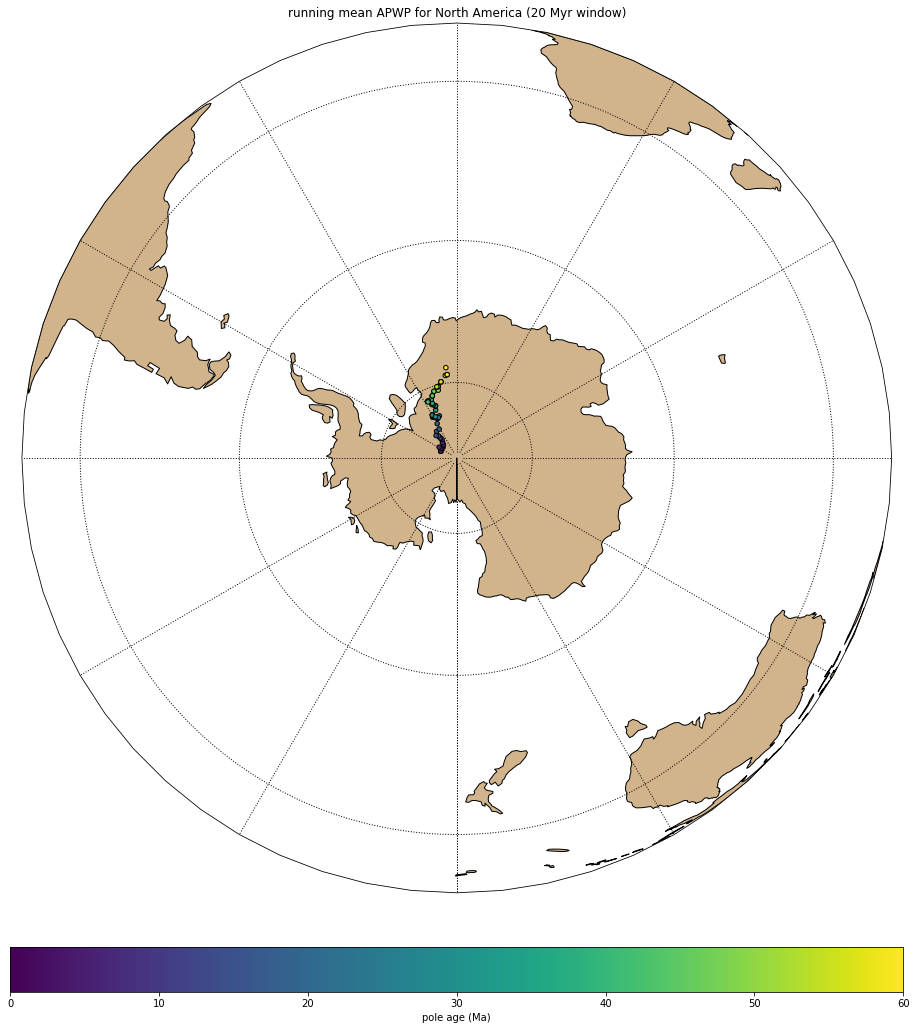

In [7]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(20,20))
ipmag.plot_poles_colorbar(map_axis, NA_RM.plon.tolist(), NA_RM.plat.tolist(), 
                 np.zeros(NA_RM.shape[0]), NA_RM.age.tolist(),0,60) #  "gist_rainbow"

plt.title('running mean APWP for North America (20 Myr window)');

### 2. Adjacent Matrix

We now minimize the loss function of the minimum circle for each possible segment in the APWP. 

In [8]:
age_min = 5.        # min age difference between change points
n_min = 4           # min number of poles in a single segment

min_apical = 30     # min apical angle
n_initials = 5      # number of iterations

In [9]:
%%time 

Adj_matrix = np.full((N, N), np.inf)
EPs = np.full((N, N, 3), np.nan, dtype=object)
Apicals = np.full((N, N), np.nan)
Res = {}

for i in range(N):
    
    for j in range(i+n_min, N):   
                
        # We ignore a path if there are not enough points to fit a circle or if the time extent of the segment is too short.
        if NA_RM.loc[j,"age"] < NA_RM.loc[i,"age"] + age_min:
            continue
            
        # We need to define the loss function from zero since it has the PP inside the function        
        X = NA_RM[i:j+1][['x', 'y', 'z']].to_numpy()                       
             
        def loss (v):
            theta, phi, varphi = v[0], v[1], v[2]                   
            res = 0
            pole = spherical2cartesian(theta, phi)
            for k in range(X.shape[0]):
                res += ( np.arccos( np.dot( X[k,:], pole)) - varphi ) ** 2        
            return res
        
        
        best = np.inf        
        for _ in range(n_initials): 
                
            initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(min_apical * (np.pi/180), np.pi / 2)] #set up random initial guess        
            optimum_tmp = minimize(loss, x0 = np.array(initialGuess), method = "CG", options = {'gtol': 1E-4})
                        
            if optimum_tmp.fun < best and optimum_tmp.x[-1] > min_apical * (np.pi/180) and optimum_tmp.x[-1] < ( 180 - min_apical) * (np.pi/180): 
                optimum = optimum_tmp
                best = optimum_tmp.fun
                
        if best < np.inf:      
            Adj_matrix[i,j] = optimum.fun
            EPs[i,j,:] = spherical2cartesian(optimum.x[0], optimum.x[1])
            Apicals[i,j] = optimum.x[2] 
            Res[(i,j)] = {"EP_cartesian": EPs[i,j,:], "apical": Apicals[i,j], "EP_polar": [optimum.x[0], optimum.x[1]]}

CPU times: user 4min 38s, sys: 349 ms, total: 4min 38s
Wall time: 4min 38s


We save the data

In [10]:
Res_dict = {"Res": Res, 
            "Adj_matrix": Adj_matrix}

import pickle
pickle.dump( Res_dict, open( "Res_NA_PEP_RM_"+str(window_rm)+".p", "wb" ) )

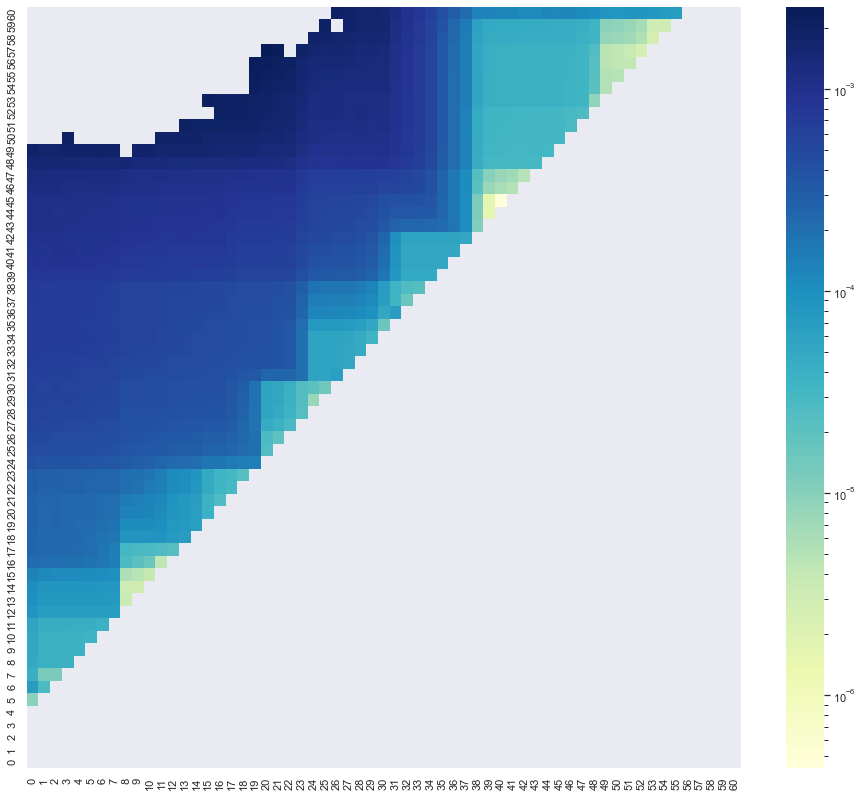

In [11]:
Adj_matrix_df = pd.DataFrame(Adj_matrix.transpose())
sns.set(rc={'figure.figsize':(16,14)})

sns.heatmap(Adj_matrix_df, cmap="YlGnBu", robust=True, norm=LogNorm()).invert_yaxis()

### 3. Estimation of the APWP

We start by defining the function that is going to find the least cost path given the adjacent matrix and a regularization parameter that penalizes path with multiple segments. 

In [12]:
def get_changepoints(Adj_matrix, reg = 0.0001):
    '''
    Given the Adjacency matrix and the regularization parameter, returns a list with changepoints along with the distance matrix
    '''    
    
    Adj_matrix_reg = Adj_matrix + reg
    
    dist_matrix, predecesors = shortest_path(Adj_matrix_reg, 
                                             return_predecessors = True)
    
    res = []
    x = predecesors[0, -1]
    
    while x != 0:
        
        res.append(x)
        x = predecesors[0, x]
        
    return list(reversed(res)), dist_matrix[0,-1]

In [13]:
N_lamb = 1000

all_lamb_log = np.linspace(-10, 6, N_lamb)
all_lamb = 10 ** all_lamb_log

all_cost, all_nsegments = [], []
AICs = []
BICs = []

Tree = np.full((N, N_lamb), 0)
Tree_lamb = []
Tree_age = []

for i, lamb in enumerate(all_lamb):    
    
    
    changepoints, total_cost = get_changepoints(Adj_matrix, reg=lamb)
    #print(changepoints)
    
    for x in changepoints:
        Tree[x, i] = 1
        Tree_lamb.append(np.log10(lamb))
        Tree_age.append(NA_RM.age[x])
    
    loss_reg = lamb * (len(changepoints) + 1) 
    #loss_reg = lamb * len(changepoints)
    cost_SQ = total_cost - loss_reg 
    
    degree_freedom = 3 * (len(changepoints)+1) + len(changepoints)
    
    all_nsegments.append(len(changepoints)+1)
    all_cost.append(total_cost)
    
    # Alkaline Information Criterion
    AIC = 2*degree_freedom + N * np.log(cost_SQ)
    # corrected AIC
    #AICc = AIC + ( 2*(degree_freedom**2) + 2*degree_freedom ) / (N - degree_freedom - 1)    
    
    AICs.append(AIC)
    
    # Bayesian Information Criterion 
    BIC = degree_freedom * np.log(N) + N * np.log(cost_SQ)
    BICs.append(BIC)

We can plot the location of the different changepoints for different values of lambda. This will give us a cascade of where to locate the changepoints for each lambda and how they increase and we increase the model complexity. Smaller values of lambda are associated to a larger model complexity, ie, more parameters. 

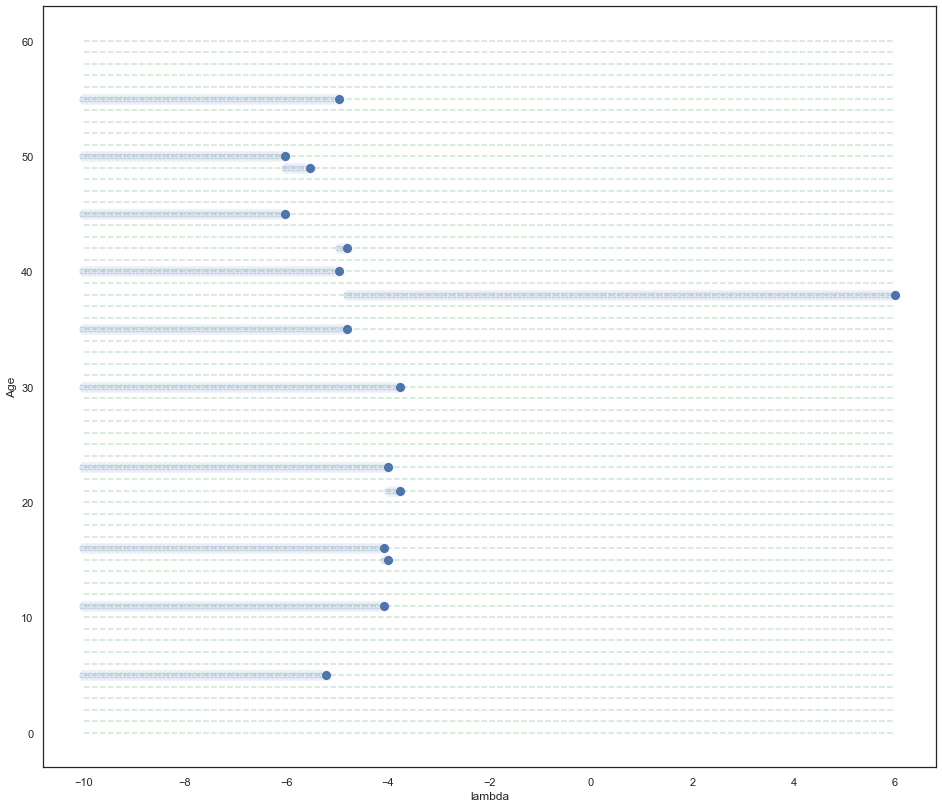

In [14]:
sns.set_style("white")
plt.hlines(y=NA_RM.age.values, xmin=all_lamb_log[0], xmax=all_lamb_log[-1], color='g', linestyle='--', alpha=.3)
sns.scatterplot(x=Tree_lamb, y=Tree_age, s=100, alpha=1)
plt.xlabel("lambda")
plt.ylabel("Age");

[38]
EP:  [-23.20469145171934 261.31586443172023]
Apical:  64.98554866561582
7.673811655612013
EP:  [ 31.692874740656293 126.21263563426723 ]
Apical:  129.0370910424295
6.619024840776056


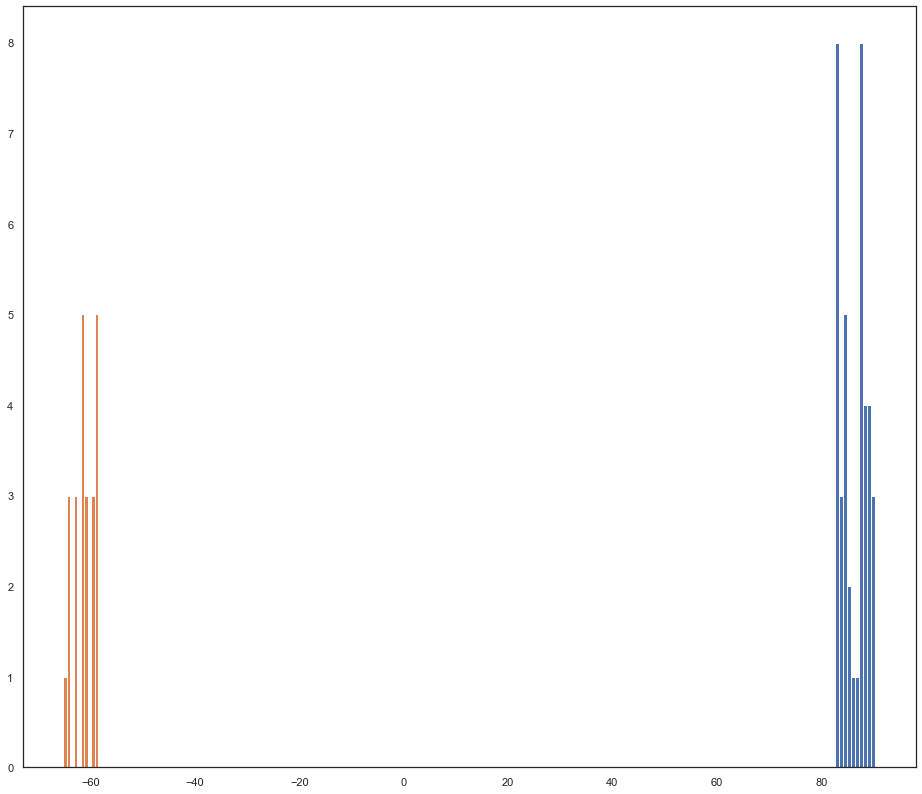

In [18]:
changepoints, total_cost = get_changepoints(Adj_matrix, reg=10**0)
print(changepoints)
segments_end = [0] + changepoints + [N-1]
segment_id = np.zeros(N)

c = 0

def cartesian2spherical2(v):  
    """
    Take an array of lenght 3 correspoingt to a 3-dimensional vector and returns a array of lenght 2
    with latitade (inclination) and longitude (declination)
    """
    theta = np.arcsin(v[2]) 
    phi = np.arctan2(v[1], v[0])
        
    return [theta, phi]


for first, second in zip(segments_end, segments_end[1:]):     
        
    segment_id[first: second+1] = c
    c += 1
    print("EP: ", (180/np.pi) * np.array(Res[first, second]['EP_polar']))
    print("Apical: ", (180/np.pi) * np.array(Res[first, second]["apical"]))
    
    ep_p = Res[first, second]['EP_polar']
    ep_c = Res[first, second]['EP_cartesian']
        
    df = NA_RM.iloc[first:second+1]  
    #print(df)
    
    # First we define the rotation we need to apply to translate the EP to the NP. This is useful (just) for estimating
    # the angular amplitude of the segment in a robust way
    
    all_poles = df[['x', 'y', 'z']].values
    
    mid_pole = ep_c + [0,0,1]
    mid_pole /= np.linalg.norm(mid_pole)
    R = rotation.from_rotvec( (np.pi) * mid_pole )
    
    all_long = [(180/np.pi)*cartesian2spherical2(R.apply(list(NA_RM.iloc[i][['x', 'y', 'z']])))[1] for i in df.index]
    #all_long = [(180/np.pi)*cartesian2spherical2(R.apply(pole)) for pole in all_poles]
    
    amplitude = np.max(all_long) - np.min(all_long)
    print(amplitude)
    plt.hist(all_long);
    
plt.show()